# Generative Dog Images
*A GAN machine learning project* 

## OVERVIEW 
Creating artificial images is an exciting concept in the machine-learning community. This competition is designed to enable new data scientists to practice and learn how to make their first fake images using a Generative Adversarial Network (GAN) model. This notebook is used to practice critical skills and learn how GANs work using authentic pictures of dogs. Essentially, we have two neural networks - a generator that generates fake photos and one that always tries to tell which images are original and which are fake. As the generator learns, it will create better and better images and (hopefully) start tricking the discriminator into thinking its pictures are real. Our goal is to generate a sufficiently realistic image so that it can also convince the discriminator.

​​​
The structure of this notebook:
1. Problem description and data
2. Exploratory Data Analysis (EDA)
3. Analysis - Model Building and Training
4. Results
5 Conclusion

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt, zipfile
import seaborn as sns
import cv2
import random
import os
import xml.etree.ElementTree as ET 
import PIL
from PIL import Image
import time
import shutil
from IPython import display
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout, BatchNormalization, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

SEED = tf.random.set_seed(49)

# 1. Description of the problem and data

The goal of this competition is to fool the computer into thinking that the images we generate are authentic. We have two compressed folders, "Annotation" and "all-dogs." The annotation contains the class label and bounding box of the image. All-dogs contain images. The images are initially different sizes. We don't get a data frame to see or plot the values. Instead, we'll go ahead and use EDA and look at some images. Before training, we set our training data (images) to "train_images," and we will normalize all photos.

In [2]:
#get filenames
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/generative-dog-images/Annotation.zip
/kaggle/input/generative-dog-images/all-dogs.zip


In [3]:
#set directory and unzip folders
if not os.path.exists('generative-dog-images'):
    !mkdir /kaggle/working/generative-dog-images
!unzip /kaggle/input/generative-dog-images/all-dogs.zip -d /kaggle/working/generative-dog-images > /dev/null 2>&1
!unzip /kaggle/input/generative-dog-images/Annotation.zip -d /kaggle/working/generative-dog-images > /dev/null 2>&1

In [4]:
#set directories and paths
all_dogs_dir = '/kaggle/working/generative-dog-images/all-dogs/'
annotation_dir = '/kaggle/working/generative-dog-images/Annotation/'

IMAGES = os.listdir(all_dogs_dir)
BREEDS = os.listdir(annotation_dir)

In [5]:
# Setup GPU accelerator - configure Strategy. Assume TPU...if not set default for GPU/CPU
tpu = None
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy()

In [6]:
print('Dog Count:', len(os.listdir(all_dogs_dir)))
print('Breed Count:', len(os.listdir(annotation_dir)))

Dog Count: 20579
Breed Count: 120


# 2. Exploratory data analysis (EDA) 
We crop the image to the bounding box and save it. Depending on the bounding box and the original image size, the size of each image before and after cropping will vary. Then we resize the image to 100x100 pixels with 3 color channels. After cropping the images, we visualize them as follows.

In [7]:
# Crop to bounding boxes such that we only have the dog(s) in the picture
# https://www.kaggle.com/paulorzp/show-annotations-and-breeds
idxIn = 0
namesIn = []
imagesIn = np.zeros((25000,100,100,3))

for breed in BREEDS: 
    for dog in os.listdir(annotation_dir+breed):
        try: img = Image.open(all_dogs_dir+dog+'.jpg') #open image
        except: continue           
        tree = ET.parse(annotation_dir+breed+'/'+dog)
        root = tree.getroot()
        objects = root.findall('object')
        for o in objects: #bounding box
            bndbox = o.find('bndbox') 
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            w = np.min((xmax - xmin, ymax - ymin))
            img2 = img.crop((xmin, ymin, xmin+w, ymin+w)) #crop to bounding box
            img2 = img2.resize((100,100), Image.ANTIALIAS) #resize to 100x100
            imagesIn[idxIn,:,:,:] = np.asarray(img2)
            namesIn.append(breed)
            idxIn += 1
idx = np.arange(idxIn)
np.random.shuffle(idx)
imagesIn = imagesIn[idx,:,:,:]
namesIn = np.array(namesIn)[idx]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.


In [8]:
#delete files now that we have images 
# and names files to make room
shutil.rmtree(all_dogs_dir)
shutil.rmtree(annotation_dir)

In [9]:
#view array shape (make sure images are 100x100x3)
imagesIn.shape

(22125, 100, 100, 3)

In [10]:
namesIn.shape

(22125,)

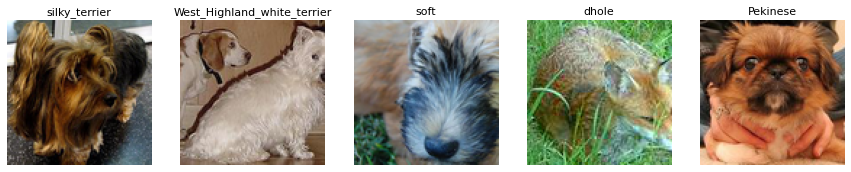

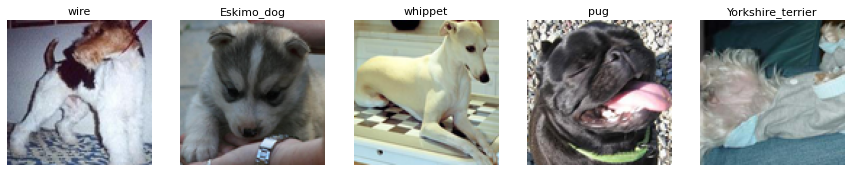

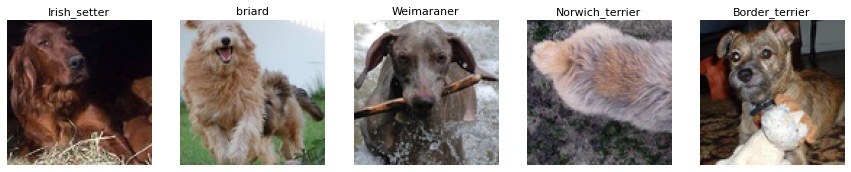

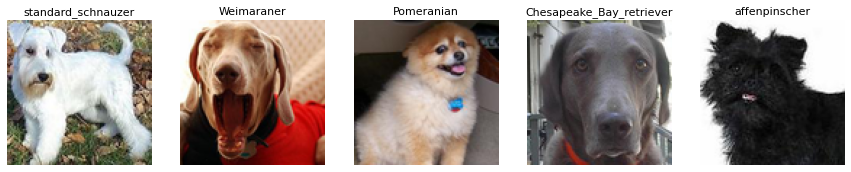

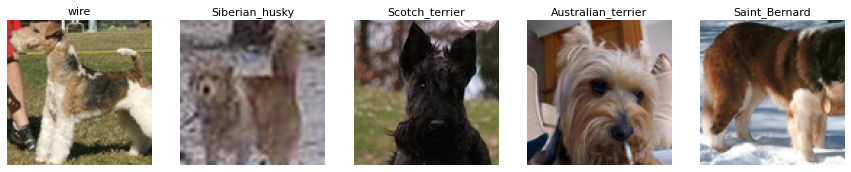

In [11]:
# visualize cropped images
x = np.random.randint(0,idxIn,25)
for k in range(5):
    plt.figure(figsize=(15,3))
    for j in range(5):
        plt.subplot(1,5,j+1)
        img = Image.fromarray(imagesIn[x[k*5+j],:,:,:].astype('uint8') )
        plt.axis('off')
        plt.title(namesIn[x[k*5+j]].split('-')[1],fontsize=11)
        plt.imshow(img)
    plt.show();

In [12]:
# normalize to [-1, 1]
train_images = imagesIn / 127.5 - 127.5
del imagesIn  
train_images.shape

(22125, 100, 100, 3)

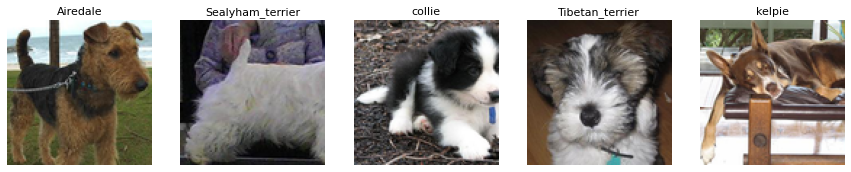

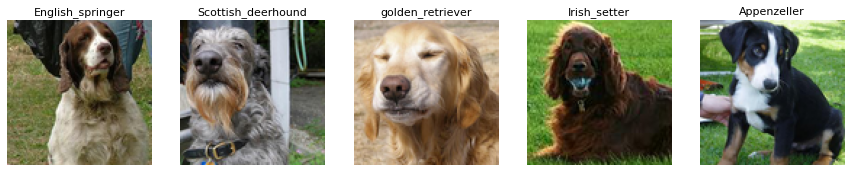

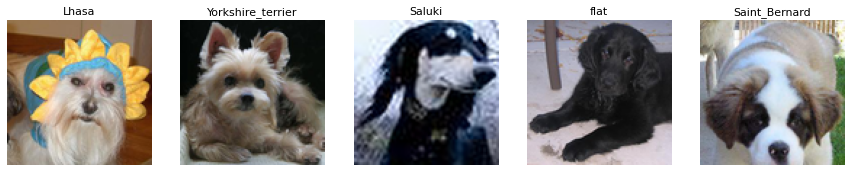

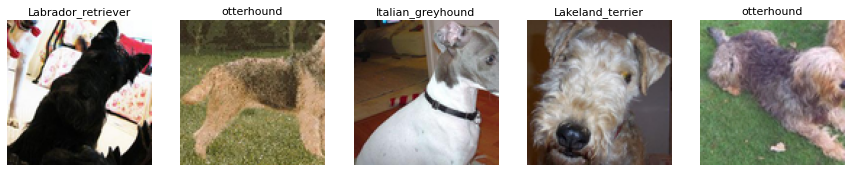

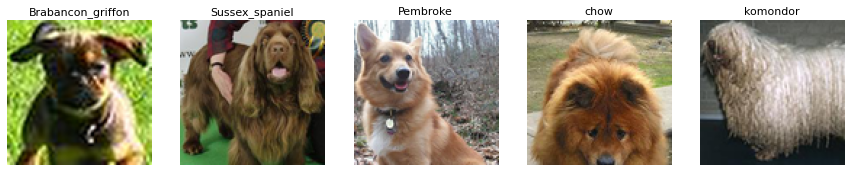

In [13]:
# Make sure we can return to 'normal' color fotos after having normalized
x = np.random.randint(0,idxIn,25)
for k in range(5):
    plt.figure(figsize=(15,3))
    for j in range(5):
        plt.subplot(1,5,j+1)
        img = Image.fromarray((train_images[x[k*5+j],:,:,:]*127.5 +127.5).astype('uint8') )
        plt.axis('off')
        plt.title(namesIn[x[k*5+j]].split('-')[1],fontsize=11)
        plt.imshow(img)
    plt.show();

# 3. Analysis - model building and training

Now for the fun part! We will begin to train our GAN model. We have cropped and normalized our data above, which is what we will use in the model. We will declare two models: generator and discriminator. The generator will create images and try to "trick" the discriminator. The discriminator will decide which images are real or fake. Our goal is to fool the discriminator such that it thinks our generated images are actually real. We will use 200 epochs, which we hope will be enough to train the models. Next, we will create 16 images per epoch so that we can see what the generator is creating. Our generator will have multiple layers using activation functions such as ReLU and Leaky ReLU. Leaky ReLU will help the function from becoming saturated at 0. 

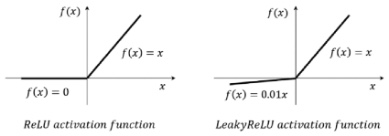

https://www.researchgate.net/figure/ReLU-activation-function-vs-LeakyReLU-activation-function_fig2_358306930

We will also use dropout layers which randomly sets input units to 0 during each training step. We will use batch normalization which normalizes its inputs by keeping the mean close to 0. In the generator model, we will use 3 as our output so that we have 3 color channels, and we will use a 'tanh' activation function which gives higher gradient values during training and more weight changes in network. In the discriminator, we will use 1 so that we have a yes/no type of response (is or isn't real), and we will use a linear activation function. As suggested by other Kagglers. For our loss functions, we will use Binary Cross Entropy. When compiling the models, we will use the Adam optimizer with a learning rate of 0.0001.

In [14]:
# set globals for training
EPOCHS = 100 
NOISE_DIM = 100
BATCH_SIZE = 256
LATENT_DIM = 100*100*3 
ONES = np.ones(BATCH_SIZE)
ZEROS = np.zeros(BATCH_SIZE)

In [15]:
#reshape images for model
train_images = train_images.reshape(-1, 100*100*3)
train_images.shape

(22125, 30000)

In [16]:
#build generator model
def create_generator(latentDim):
    with strategy.scope():

        inputs = Input(shape=(latentDim, ))
        gen = layers.Dense(256, activation=LeakyReLU(alpha=0.2))(inputs) 
        gen = layers.BatchNormalization(momentum=0.8)(gen) 
        gen = layers.Dense(512, activation=LeakyReLU(alpha=0.2))(gen)
        gen = layers.BatchNormalization(momentum=0.8)(gen)
        gen = layers.Dense(1024, activation=LeakyReLU(alpha=0.2))(gen)
        gen = layers.BatchNormalization(momentum=0.8)(gen)
        gen = Dense(100*100*3, activation='tanh')(gen)
        model = Model(inputs, gen)
        return model

In [17]:
#build discriminator model
def create_discriminator(image_size):
    with strategy.scope():

        inputs = Input(shape=(image_size, ))
        disc = layers.Dense(512, activation=LeakyReLU(alpha=0.2))(inputs)
        disc = layers.Dense(256, activation=LeakyReLU(alpha=0.2))(disc)
        disc = layers.Dense(1, activation='sigmoid')(disc)
        model = Model(inputs, disc)
        return model

In [18]:
with strategy.scope():

    #build discriminator 
    discriminator = create_discriminator(100*100*3) 
    discriminator.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                          optimizer=tf.keras.optimizers.Adam(0.0001), 
                          metrics=['accuracy'])

2022-10-14 15:16:45.850091: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-14 15:16:46.003924: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-14 15:16:46.004732: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-14 15:16:46.007798: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [19]:
#build combined model
generator = create_generator(LATENT_DIM)

In [20]:
print(' ############## GENERATOR MODEL ##############')
generator.summary()
print('\n', '############## DISCRIMINATOR MODEL ##############')
discriminator.summary()

 ############## GENERATOR MODEL ##############
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 30000)]           0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               7680256   
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_4 (Dense)              (None, 512)               131584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              525312    
_________________________________________________________________
batch_normal

Prediction =  tf.Tensor([[0.52924997]], shape=(1, 1), dtype=float32)


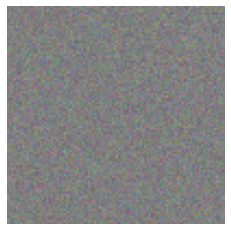

In [21]:
#visualize example and make sure its working correct
noise = tf.random.normal([1, LATENT_DIM])
image = generator(noise)
discriminator.trainable = False
prediction = discriminator(image)
image = (tf.reshape(image, (100,100,3)).numpy()* 127.5 + 127.5).astype(int) 
plt.imshow(image);
plt.axis('off')
print("Prediction = ", prediction)

In [22]:
with strategy.scope():

    #compile model completely using noise image as our starting point
    noise = Input(shape=(LATENT_DIM, ))
    image = generator(noise)
    prediction = discriminator(image)

    GAN = Model(noise, prediction) 

    GAN.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                          optimizer=tf.keras.optimizers.Adam(0.0001))

In [23]:
#create folder to save generator images
if not os.path.exists('GAN_images'):
    os.makedirs('GAN_images')

In [24]:
#produce sample images
def sample_images(epoch):
    rows = 5
    cols = 5
    noise = np.random.randn(rows*cols, LATENT_DIM)
    images = generator.predict(noise)
    images = (tf.reshape(images, (images.shape[0], 100,100,3)).numpy()* 127.5 + 127.5).astype(int) 
    fig, axs = plt.subplots(rows, cols)
    index = 0
    for r in range(rows):
        for c in range(cols): 
            axs[r,c].imshow(images[index])
            axs[r,c].axis('off')
            index+=1
    plt.show()
    fig.savefig('GAN_images/%d.png' % epoch) 
    plt.close()

2022-10-14 15:16:50.212159: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


epoch: 1/100, disc_loss: 0.3635, gen_loss: 0.8432
Fake Images at Epoch: 1/100


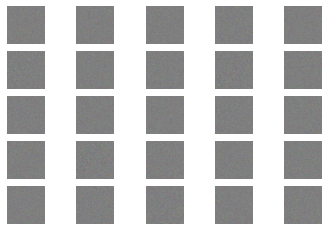

epoch: 2/100, disc_loss: 0.2052, gen_loss: 0.8355
epoch: 3/100, disc_loss: 0.1946, gen_loss: 0.7726
epoch: 4/100, disc_loss: 0.2248, gen_loss: 0.6818
epoch: 5/100, disc_loss: 0.2352, gen_loss: 0.5868
epoch: 6/100, disc_loss: 0.2342, gen_loss: 0.5174
epoch: 7/100, disc_loss: 0.2179, gen_loss: 0.4345
epoch: 8/100, disc_loss: 0.1891, gen_loss: 0.3817
epoch: 9/100, disc_loss: 0.1674, gen_loss: 0.3359
epoch: 10/100, disc_loss: 0.1496, gen_loss: 0.3009
epoch: 11/100, disc_loss: 0.1405, gen_loss: 0.2833
Fake Images at Epoch: 11/100


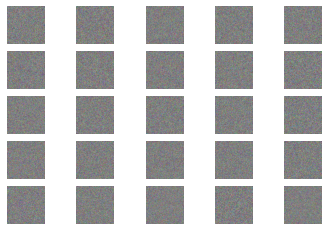

epoch: 12/100, disc_loss: 0.1533, gen_loss: 0.3334
epoch: 13/100, disc_loss: 0.1838, gen_loss: 0.3860
epoch: 14/100, disc_loss: 0.2084, gen_loss: 0.4496
epoch: 15/100, disc_loss: 0.2345, gen_loss: 0.5152
epoch: 16/100, disc_loss: 0.2630, gen_loss: 0.5597
epoch: 17/100, disc_loss: 0.2756, gen_loss: 0.5756
epoch: 18/100, disc_loss: 0.2753, gen_loss: 0.5915
epoch: 19/100, disc_loss: 0.2883, gen_loss: 0.5867
epoch: 20/100, disc_loss: 0.2766, gen_loss: 0.5847
epoch: 21/100, disc_loss: 0.2777, gen_loss: 0.5625
Fake Images at Epoch: 21/100


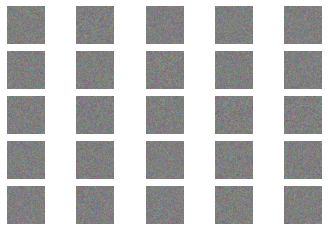

epoch: 22/100, disc_loss: 0.2567, gen_loss: 0.5635
epoch: 23/100, disc_loss: 0.2750, gen_loss: 0.5383
epoch: 24/100, disc_loss: 0.2503, gen_loss: 0.5244
epoch: 25/100, disc_loss: 0.2405, gen_loss: 0.4912
epoch: 26/100, disc_loss: 0.2359, gen_loss: 0.4738
epoch: 27/100, disc_loss: 0.2376, gen_loss: 0.4624
epoch: 28/100, disc_loss: 0.2209, gen_loss: 0.4615
epoch: 29/100, disc_loss: 0.2178, gen_loss: 0.4422
epoch: 30/100, disc_loss: 0.2237, gen_loss: 0.4482
epoch: 31/100, disc_loss: 0.2116, gen_loss: 0.4414
Fake Images at Epoch: 31/100


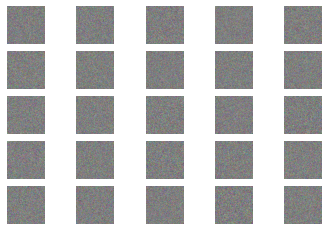

epoch: 32/100, disc_loss: 0.2243, gen_loss: 0.4278
epoch: 33/100, disc_loss: 0.2108, gen_loss: 0.4379
epoch: 34/100, disc_loss: 0.2113, gen_loss: 0.4334
epoch: 35/100, disc_loss: 0.2091, gen_loss: 0.4189
epoch: 36/100, disc_loss: 0.2070, gen_loss: 0.4117
epoch: 37/100, disc_loss: 0.2026, gen_loss: 0.4096
epoch: 38/100, disc_loss: 0.1930, gen_loss: 0.4125
epoch: 39/100, disc_loss: 0.1965, gen_loss: 0.3915
epoch: 40/100, disc_loss: 0.1982, gen_loss: 0.3910
epoch: 41/100, disc_loss: 0.1969, gen_loss: 0.3746
Fake Images at Epoch: 41/100


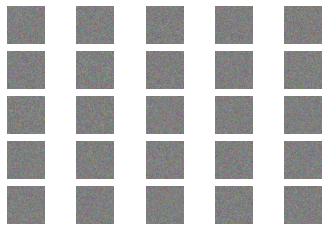

epoch: 42/100, disc_loss: 0.1956, gen_loss: 0.3832
epoch: 43/100, disc_loss: 0.1863, gen_loss: 0.3729
epoch: 44/100, disc_loss: 0.1744, gen_loss: 0.3542
epoch: 45/100, disc_loss: 0.1707, gen_loss: 0.3565
epoch: 46/100, disc_loss: 0.1813, gen_loss: 0.3453
epoch: 47/100, disc_loss: 0.1631, gen_loss: 0.3443
epoch: 48/100, disc_loss: 0.1643, gen_loss: 0.3402
epoch: 49/100, disc_loss: 0.1649, gen_loss: 0.3295
epoch: 50/100, disc_loss: 0.1628, gen_loss: 0.3183
epoch: 51/100, disc_loss: 0.1598, gen_loss: 0.3235
Fake Images at Epoch: 51/100


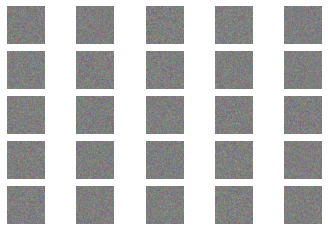

epoch: 52/100, disc_loss: 56.3362, gen_loss: 0.4493
epoch: 53/100, disc_loss: 0.2538, gen_loss: 0.5738
epoch: 54/100, disc_loss: 0.3086, gen_loss: 0.7198
epoch: 55/100, disc_loss: 0.3499, gen_loss: 0.8232
epoch: 56/100, disc_loss: 0.4149, gen_loss: 0.9024
epoch: 57/100, disc_loss: 0.4840, gen_loss: 0.9168
epoch: 58/100, disc_loss: 0.4714, gen_loss: 0.9682
epoch: 59/100, disc_loss: 0.4903, gen_loss: 1.0121
epoch: 60/100, disc_loss: 0.4433, gen_loss: 1.0448
epoch: 61/100, disc_loss: 0.4880, gen_loss: 1.0254
Fake Images at Epoch: 61/100


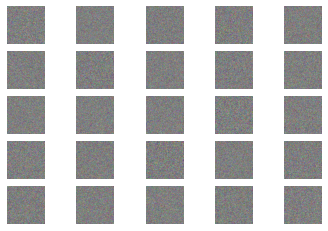

epoch: 62/100, disc_loss: 0.6178, gen_loss: 1.0396
epoch: 63/100, disc_loss: 0.5237, gen_loss: 1.0642
epoch: 64/100, disc_loss: 0.6221, gen_loss: 1.1892
epoch: 65/100, disc_loss: 0.6365, gen_loss: 1.1469
epoch: 66/100, disc_loss: 0.5684, gen_loss: 1.1313
epoch: 67/100, disc_loss: 0.6224, gen_loss: 1.2181
epoch: 68/100, disc_loss: 0.5744, gen_loss: 1.2676
epoch: 69/100, disc_loss: 0.6400, gen_loss: 1.1589
epoch: 70/100, disc_loss: 0.5444, gen_loss: 1.2163
epoch: 71/100, disc_loss: 0.6436, gen_loss: 1.2514
Fake Images at Epoch: 71/100


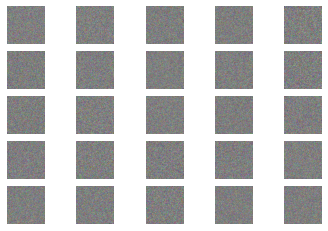

epoch: 72/100, disc_loss: 0.5881, gen_loss: 1.2093
epoch: 73/100, disc_loss: 0.5770, gen_loss: 1.1962
epoch: 74/100, disc_loss: 0.6036, gen_loss: 1.2548
epoch: 75/100, disc_loss: 0.4804, gen_loss: 1.2023
epoch: 76/100, disc_loss: 0.5594, gen_loss: 1.2120
epoch: 77/100, disc_loss: 0.6423, gen_loss: 1.2549
epoch: 78/100, disc_loss: 0.6473, gen_loss: 1.1714
epoch: 79/100, disc_loss: 0.6021, gen_loss: 1.1665
epoch: 80/100, disc_loss: 0.6667, gen_loss: 1.2381
epoch: 81/100, disc_loss: 0.6446, gen_loss: 1.2186
Fake Images at Epoch: 81/100


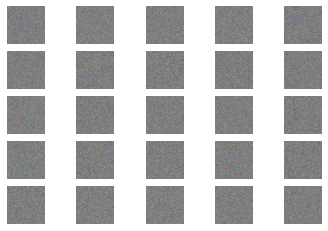

epoch: 82/100, disc_loss: 0.6498, gen_loss: 1.2237
epoch: 83/100, disc_loss: 0.6168, gen_loss: 1.1247
epoch: 84/100, disc_loss: 0.6106, gen_loss: 1.1226
epoch: 85/100, disc_loss: 0.5593, gen_loss: 1.2374
epoch: 86/100, disc_loss: 0.6306, gen_loss: 1.1352
epoch: 87/100, disc_loss: 0.5823, gen_loss: 1.1346
epoch: 88/100, disc_loss: 0.5347, gen_loss: 1.1184
epoch: 89/100, disc_loss: 0.5389, gen_loss: 1.1210
epoch: 90/100, disc_loss: 0.5236, gen_loss: 1.0782
epoch: 91/100, disc_loss: 0.5263, gen_loss: 1.0566
Fake Images at Epoch: 91/100


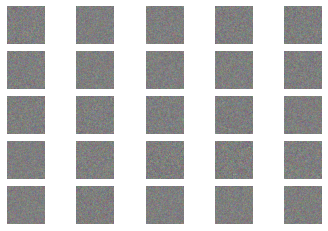

epoch: 92/100, disc_loss: 0.5578, gen_loss: 1.0281
epoch: 93/100, disc_loss: 0.5362, gen_loss: 1.0101
epoch: 94/100, disc_loss: 0.5136, gen_loss: 1.0050
epoch: 95/100, disc_loss: 0.4863, gen_loss: 1.0048
epoch: 96/100, disc_loss: 0.5432, gen_loss: 0.9828
epoch: 97/100, disc_loss: 0.5155, gen_loss: 0.9738
epoch: 98/100, disc_loss: 0.4921, gen_loss: 0.9938
epoch: 99/100, disc_loss: 0.4465, gen_loss: 0.9641
epoch: 100/100, disc_loss: 0.4530, gen_loss: 0.9848


In [25]:
#create losses
discriminator_loss = []
generator_loss = []

# training
for epoch in range(EPOCHS):
    #get batches of real images
    index = np.random.randint(0, train_images.shape[0], BATCH_SIZE) ###################################
    real_images = train_images[index]
    
    #get fake images
    noise = np.random.randn(BATCH_SIZE, LATENT_DIM)
    fake_images = generator.predict(noise)
    
    #train 
    disc_loss_real, disc_acc_real = discriminator.train_on_batch(real_images, ONES)
    disc_loss_fake, disc_acc_fake = discriminator.train_on_batch(fake_images, ZEROS)
    disc_loss = 0.5 * (disc_loss_real + disc_loss_fake)
    disc_acc = 0.5 * (disc_loss_real + disc_loss_fake)
    
    #train generator 
    noise = np.random.randn(BATCH_SIZE, LATENT_DIM)
    gen_loss = GAN.train_on_batch(noise, ONES)
    noise = np.random.randn(BATCH_SIZE, LATENT_DIM)
    gen_loss = GAN.train_on_batch(noise, ZEROS)
    
    #save loss
    discriminator_loss.append(disc_loss)
    generator_loss.append(gen_loss)
    
    print(f"epoch: {epoch+1}/{EPOCHS}, disc_loss: {disc_loss:.4f}, gen_loss: {gen_loss:.4f}")
    
    if epoch % 10 == 0:
        print(f'Fake Images at Epoch: {epoch+1}/{EPOCHS}')
        sample_images(epoch)

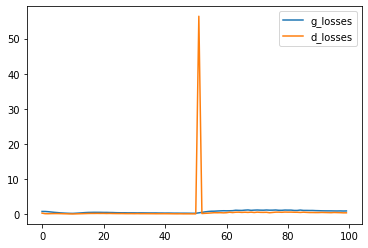

In [26]:
plt.plot(generator_loss, label='g_losses')
plt.plot(discriminator_loss, label='d_losses')
plt.legend();

# 4. Result 

It looks like our model learned something! Great! Since we can't submit the project anymore (past competition dates), we can't see how well our model is performing so far. However, we can see that the model started to get more browns and started to form some sort of shape-like figures. However, it is obvious these are not dogs, or anything like it. As a first GAN project, I'm satisified that the model was able to run and start to learn something. After 200 epochs and many hours of waiting for the model to train, I've decided this is as far as I'll take it for this mini-project. We can see that the model was learning and (hopefully) improving. During this project, I tried modifying many parts of the model to try and get a better outcome such as different activation functions, different momentum values, different number of Convolutional layers, and different values of dropout. In all, since these models take so long to train, I tried 3 different combinations of values and structure and this was the best result thus far. In the conclusion, we'll discuss ways to improve the model. 

In [27]:
#save images in zip
z = zipfile.PyZipFile('images.zip', mode='w')

#save model
model_filename = 'generator_model.h5'
tf.keras.models.save_model(generator, model_filename, overwrite=True, include_optimizer=True, save_format=None)

# 5. Conclusion

Our model did learn and begin to take shape. However, it is obvious our model did not create convincing dog images. There are a few suggestions: increase the number of epochs, modify the architecture and/or try transfer learning. Something that I would have liked to try was transfer learning during the generator part so that the model doesn't have to learn from 0. In addition, I think increasing the number of epochs would have useful. As we can see in the generated images, we are just now starting to get more "dog-like" colors and begining to create shapes. GANs are complex models which require much patience and knowledge. This project just scrapes the surface of GANs and how much they can accomplish. 

For some cool inspiration for GANs and what they can do: https://machinelearningmastery.com/impressive-applications-of-generative-adversarial-networks/

  
   
.

.

.

.

.

.

.
       

This notebook was inspired from the Tensorflow website (https://www.tensorflow.org/tutorials/generative/dcgan) because this was my first GAN project and I needed guidance on how to make it work, as well as https://www.kaggle.com/code/jpdurham/tensorflow-dcgan and https://www.analyticsvidhya.com/blog/2021/10/an-end-to-end-introduction-to-generative-adversarial-networksgans/.
